In [33]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler

import os
import h5py
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = "1,2"
from time import time

import FrEIA.framework  as Ff
import FrEIA.modules as Fm

import losses
import monitoring
from utils import ScatterindPerShape
from copy import deepcopy

from visualizations import plot_outcomes_identified, describe_false_shapes, describe_positive_shapes
import seaborn as sns

In [17]:
def violinplot_feature_shape(df_test,  sampled_inputs, feature):
    """
    Feature is either shape name, which will yield the radius
    or the one of the keys in the `indexer`.
    """
    indexer = {'radius_pd'   :3,
                'length'     :4,
                'length_pd'  :5,
                'volfraction':6}
    if feature =='sphere':
        pred = df_test[:, 0]
        sampled = sampled_inputs[:, 0]
    elif feature == 'hardsphere':
        pred = df_test[:, 1]
        sampled = sampled_inputs[:, 1]
    elif feature == 'cylinder':
        pred = df_test[:, 2]
        sampled = sampled_inputs[:, 2]
    else:
        pred = df_test[:, indexer[feature]]
        sampled = sampled_inputs[:, indexer[feature]]
    df = pd.concat([pd.DataFrame({'value': sampled, 'feature':'sampled'}),pd.DataFrame({'value': pred, 'feature':'predicted'})])
    sns.violinplot(df, y = 'value', x = 'feature') # can't generalize

In [69]:
filename_out    = 'output/inn_per_shape.pt'
# Model to load and continue training. Ignored if empty string
filename_in     = ''
# Compute device to perform the training on, 'cuda' or 'cpu'
device          = 'cuda'
# Use interactive visualization of losses and other plots. Requires visdom
interactive_visualization = False # check first how this visdom works
# Run a list of python functions at test time after eacch epoch
# See toy_modes_train.py for reference example
test_time_functions = []

#######################
#  Training schedule  #
#######################

# Initial learning rate
lr_init         = 1e-1
#Batch size
batch_size      = 128
# Total number of epochs to train for
n_epochs        = 20

# End the epoch after this many iterations (or when the train loader is exhausted)
n_its_per_epoch = 200
# For the first n epochs, train with a much lower learning rate. This can be
# helpful if the model immediately explodes.
pre_low_lr      = 0
# Decay exponentially each epoch, to final_decay*lr_init at the last epoch.
final_decay     = 0.02
# L2 weight regularization of model parameters
l2_weight_reg   = 1e-5
# Parameters beta1, beta2 of the Adam optimizer
adam_betas = (0.9, 0.95)

#####################
#  Data dimensions  #
#####################
ndim_x_class     = 3
ndim_x_features     = 7
ndim_pad_x_features = 585
ndim_pad_x_class = 0

ndim_y     = 512
ndim_z     = 2
ndim_pad_zy = 78 

# Overwrite or import data loaders here.
# See dkfz_train.py for reference.
#from my_loaders import train_loader, test_loader

train_loader, test_loader = None, None

assert ( ndim_x_features + ndim_pad_x_features 
        == ndim_y + ndim_z + ndim_pad_zy), "Dimensions don't match up"

############
#  Losses  #
############

train_forward_mmd    = True
train_backward_mmd   = True
train_reconstruction = False
train_max_likelihood = False

lambd_fit_forw         = 0.1
lambd_mmd_forw         = 100.
lambd_reconstruct      = 1.
lambd_mmd_back_feature = 500.
lambd_mmd_back_class = 0
# Both for fitting, and for the reconstruction, perturb y with Gaussian 
# noise of this sigma
add_y_noise     = 5e-2 # think of smth smart here
# For reconstruction, perturb z 
add_z_noise     = 2e-2
# In all cases, perturb the zero padding
add_pad_noise   = 1e-2

# For noisy forward processes, the sigma on y (assumed equal in all dimensions).
# This is only used if mmd_back_weighted of train_max_likelihoiod are True.
y_uncertainty_sigma = 0.12 * 4

mmd_forw_kernels = [(0.2, 1/2), (1.5, 1/2), (3.0, 1/2)]
mmd_back_kernels = [(0.2, 1/2), (0.2, 1/2), (0.2, 1/2)]
mmd_back_weighted = True

###########
#  Model  #
###########

# Initialize the model parameters from a normal distribution with this sigma
init_scale = 0.10
#
N_blocks   = 5
#
exponent_clamping = 3.0
#
hidden_layer_sizes = 64
#
use_permutation = True
#
verbose_construction = False

In [3]:
learning_problem = ScatterindPerShape( device,  batch_size, ndim_x_class, ndim_x_features, ndim_y, ndim_z, ndim_pad_x_class, ndim_pad_x_features,
                       ndim_pad_zy, init_scale, final_decay, n_epochs, lr_init, adam_betas, l2_weight_reg, lambd_fit_forw, 
                       lambd_mmd_forw, lambd_mmd_back_class, lambd_mmd_back_feature, lambd_reconstruct, mmd_back_weighted, 
                       y_uncertainty_sigma, add_pad_noise, add_z_noise, add_y_noise, n_its_per_epoch, pre_low_lr, filename_out, mmd_forw_kernels, mmd_back_kernels)

In [4]:
learning_problem.read_data('/home/slaskina/simulations')

In [28]:
def subnet(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, hidden_layer_sizes), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes,  hidden_layer_sizes), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes,  dims_out))



input = Ff.InputNode(ndim_x_features + ndim_pad_x_features, name='input_features')

nodes = [input]
for i in range(N_blocks):
    nodes.append(Ff.Node(nodes[-1].out0, Fm.RNVPCouplingBlock, {'subnet_constructor':subnet, 'clamp':exponent_clamping}, name = 'coupling_{}'.format(i)))
    if use_permutation:
        nodes.append(Ff.Node([nodes[-1].out0], Fm.PermuteRandom, {'seed':i}, name='permute_{}'.format(i)))

nodes.append(Ff.OutputNode([nodes[-1].out0], name='output'))
model_sphere = Ff.GraphINN(nodes, verbose=verbose_construction)

model_hardsphere = Ff.GraphINN(nodes, verbose=verbose_construction)

model_cylinder = Ff.GraphINN(nodes, verbose=verbose_construction)


## Sphere

In [70]:
spheres_LP = deepcopy(learning_problem)
spheres_LP.extract_shape('sphere')
spheres_LP.normalize_inputs()

In [71]:
spheres_LP.update_hyperparameters(device,  batch_size, ndim_x_class, ndim_x_features, ndim_y, ndim_z, ndim_pad_x_class, ndim_pad_x_features,
                       ndim_pad_zy, init_scale, final_decay, n_epochs, lr_init, adam_betas, l2_weight_reg, lambd_fit_forw, 
                       lambd_mmd_forw, lambd_mmd_back_class, lambd_mmd_back_feature, lambd_reconstruct, mmd_back_weighted, 
                       y_uncertainty_sigma, add_pad_noise, add_z_noise, add_y_noise, n_its_per_epoch, pre_low_lr, filename_out, mmd_forw_kernels, mmd_back_kernels)

spheres_LP.create_loaders()                    
spheres_LP.set_model(model_sphere)
spheres_LP.set_optimizer()
spheres_LP.train()
df_test = spheres_LP.make_prediction(spheres_LP.test_indices)

Epoch            L_fit       L_mmd_fwd      L_mmd_back       L_reconst     L_fit(test) L_mmd_fwd(test) L_mmd_back(test) L_reconst(test)
   000         28.2522          0.7409             nan         25.6952          0.6210             nan
   001         25.5258          0.6197             nan         25.4365          0.6283             nan
   002         25.4367          0.6228             nan         25.4342          0.6185             nan
   003         25.4359          0.6167             nan         25.4362          0.6253             nan
   004         25.4394          0.6182             nan         25.4390          0.6235             nan
   005         25.4284          0.6193             nan         25.4190          0.6234             nan
   006         25.3873          0.6199             nan         25.2414          0.6316             nan
   007         25.1826          0.6308             nan         25.1291          0.6338             nan
   008         25.0860          0.6238  

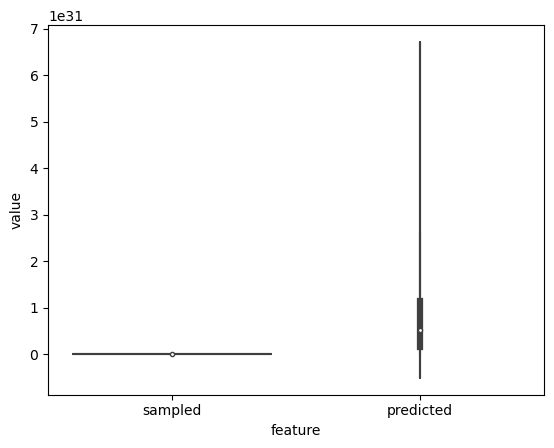

In [72]:
violinplot_feature_shape(df_test, spheres_LP.inputs[spheres_LP.test_indices], 'sphere')

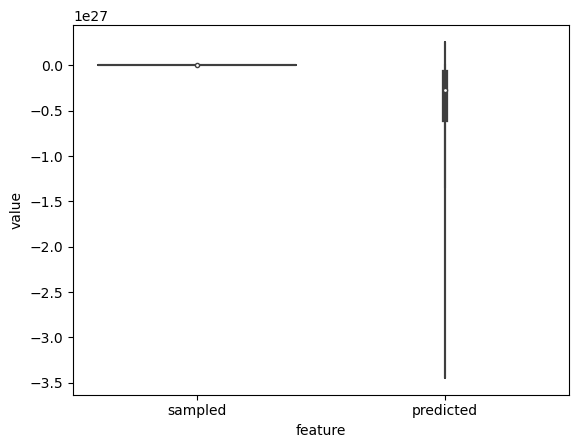

In [73]:
violinplot_feature_shape(df_test, spheres_LP.inputs[spheres_LP.test_indices], 'radius_pd')

## Hardsphere

In [ ]:
hardspheres_LP = deepcopy(learning_problem)
hardspheres_LP.extract_shape('hardsphere')
hardspheres_LP.normalize_inputs()

Config options:

  N_blocks                 	5
  adam_betas               	(0.9, 0.95)
  add_pad_noise            	0.01
  add_y_noise              	0.05
  add_z_noise              	0.02
  batch_size               	256
  device                   	cuda
  exponent_clamping        	3.0
  filename_in              	
  filename_out             	output/my_inn.pt
  final_decay              	0.02
  hidden_layer_sizes       	16
  init_scale               	0.1
  interactive_visualization	False
  l2_weight_reg            	1e-05
  lambd_fit_forw           	10.0
  lambd_max_likelihood     	1.0
  lambd_mmd_back_class     	500.0
  lambd_mmd_back_feature   	50.0
  lambd_mmd_forw           	50.0
  lambd_reconstruct        	1.0
  lr_init                  	0.001
  mmd_back_kernels         	[(0.2, 0.1), (0.2, 0.5), (0.2, 2)]
  mmd_back_weighted        	True
  mmd_forw_kernels         	[(0.2, 2), (1.5, 2), (3.0, 2)]
  n_epochs                 	25
  n_its_per_epoch          	200
  ndim_pad_x_class         	39

In [ ]:
hardspheres_LP.update_hyperparameters(device,  batch_size, ndim_x_class, ndim_x_features, ndim_y, ndim_z, ndim_pad_x_class, ndim_pad_x_features,
                       ndim_pad_zy, init_scale, final_decay, n_epochs, lr_init, adam_betas, l2_weight_reg, lambd_fit_forw, 
                       lambd_mmd_forw, lambd_mmd_back_class, lambd_mmd_back_feature, lambd_reconstruct, mmd_back_weighted, 
                       y_uncertainty_sigma, add_pad_noise, add_z_noise, add_y_noise, n_its_per_epoch, pre_low_lr, filename_out, mmd_forw_kernels, mmd_back_kernels)

hardspheres_LP.create_loaders()                    
hardspheres_LP.set_model(model_hardsphere)
hardspheres_LP.set_optimizer()
hardspheres_LP.train()
df_test = hardspheres_LP.make_prediction(hardspheres_LP.test_indices)

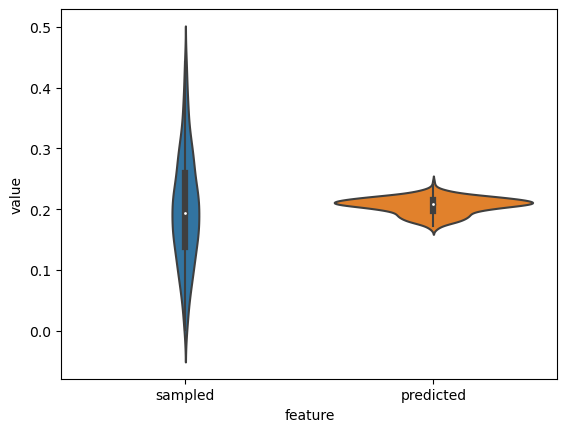

In [ ]:
violinplot_feature_shape(df_test, hardspheres_LP.inputs[hardspheres_LP.test_indices], 'hardsphere')

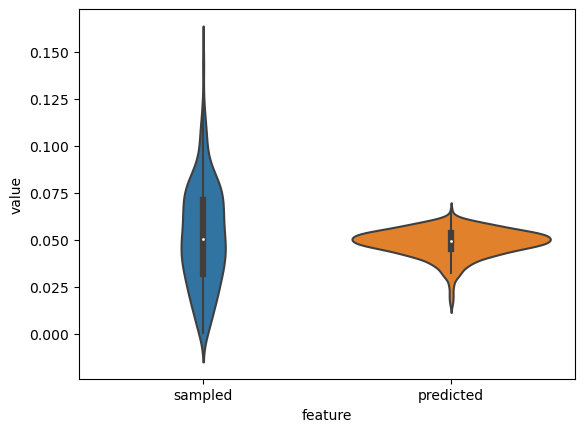

In [ ]:
violinplot_feature_shape(df_test, hardspheres_LP.inputs[hardspheres_LP.test_indices],  'radius_pd')

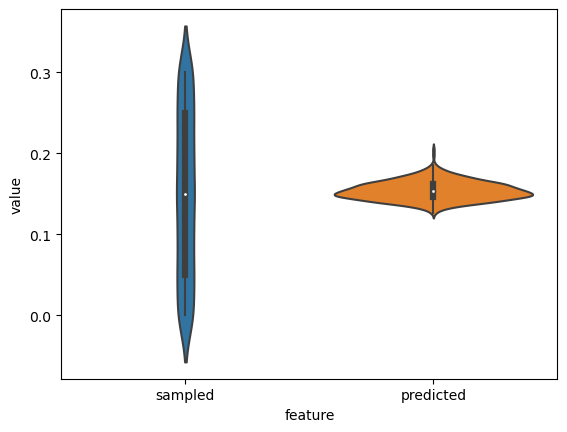

In [ ]:
violinplot_feature_shape(df_test, hardspheres_LP.inputs[hardspheres_LP.test_indices],  'volfraction')

## Cylinder

In [ ]:
cylinders_LP = deepcopy(learning_problem)
cylinders_LP.extract_shape('cylinders')
cylinders_LP.normalize_inputs()

UnboundLocalError: local variable 't_start' referenced before assignment

In [ ]:
cylinders_LP.update_hyperparameters(device,  batch_size, ndim_x_class, ndim_x_features, ndim_y, ndim_z, ndim_pad_x_class, ndim_pad_x_features,
                       ndim_pad_zy, init_scale, final_decay, n_epochs, lr_init, adam_betas, l2_weight_reg, lambd_fit_forw, 
                       lambd_mmd_forw, lambd_mmd_back_class, lambd_mmd_back_feature, lambd_reconstruct, mmd_back_weighted, 
                       y_uncertainty_sigma, add_pad_noise, add_z_noise, add_y_noise, n_its_per_epoch, pre_low_lr, filename_out, mmd_forw_kernels, mmd_back_kernels)

cylinders_LP.create_loaders()                    
cylinders_LP.set_model(model_cylinder)
cylinders_LP.set_optimizer()
cylinders_LP.train()
df_test = cylinders_LP.make_prediction(cylinders_LP.test_indices)

In [ ]:
violinplot_feature_shape(df_test, cylinders_LP.inputs[cylinders_LP.test_indices], 'cylinder')

NameError: name 'violinplot_feature_shape' is not defined

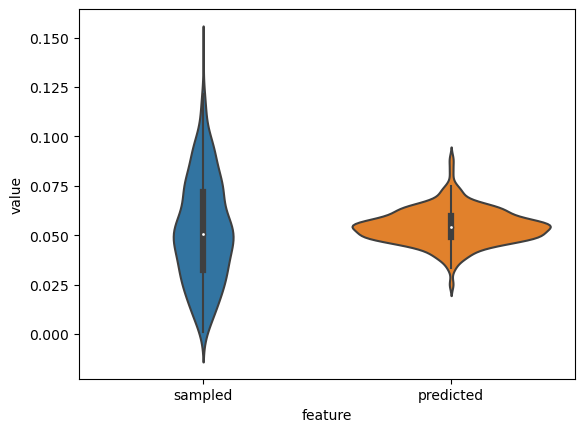

In [ ]:
violinplot_feature_shape(df_test, cylinders_LP.inputs[cylinders_LP.test_indices], 'radius_pd')

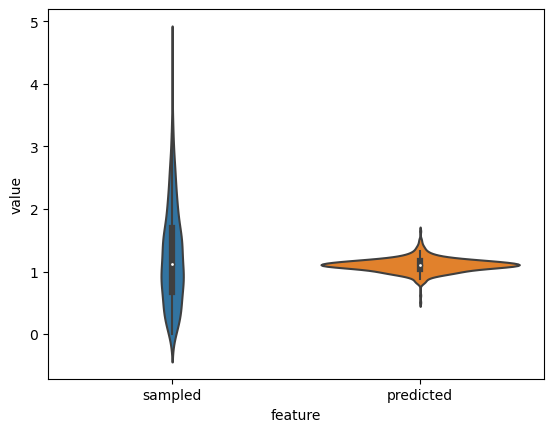

In [ ]:
violinplot_feature_shape(df_test, cylinders_LP.inputs[cylinders_LP.test_indices], 'length')

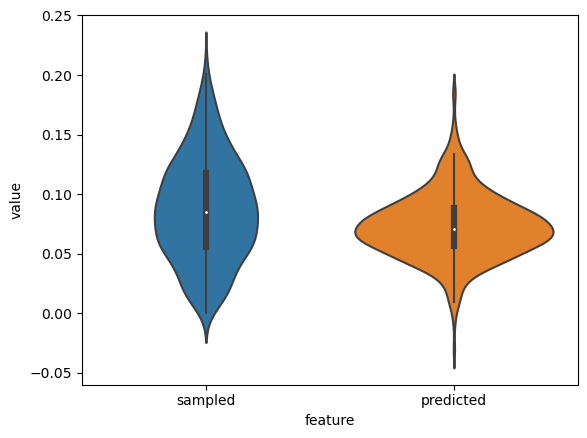

In [ ]:
violinplot_feature_shape(df_test, cylinders_LP.inputs[cylinders_LP.test_indices], 'length_pd')